# **MNIST Classification**
## การแยกประเภทของภาพตัวเลข Dataset MNIST
### สำหรับ Advance Custom Dataset ให้ไปที่ [ลิงก์นี้](https://colab.research.google.com/drive/10vTdXjiCPW1kwW_u1bSDBYTqRGaNsd5D?usp=sharing) แทน
ออกแบบโดย Leagues of Code TH

อัพเดทล่าสุด 17 เมษายน 2568

# **1 Introduction**

ใน Notebook ฉบับนี้ เราจะมาสร้าง Model AI สำหรับการแยกประเภท (Classification) ของรูปภาพตัวเลขสำหรับ Dataset MNIST น้อง ๆ สามารถเข้าไปดูตัวอย่าง Dataset นี้ได้จาก [Wikipedia:MNIST](https://en.wikipedia.org/wiki/MNIST_database)

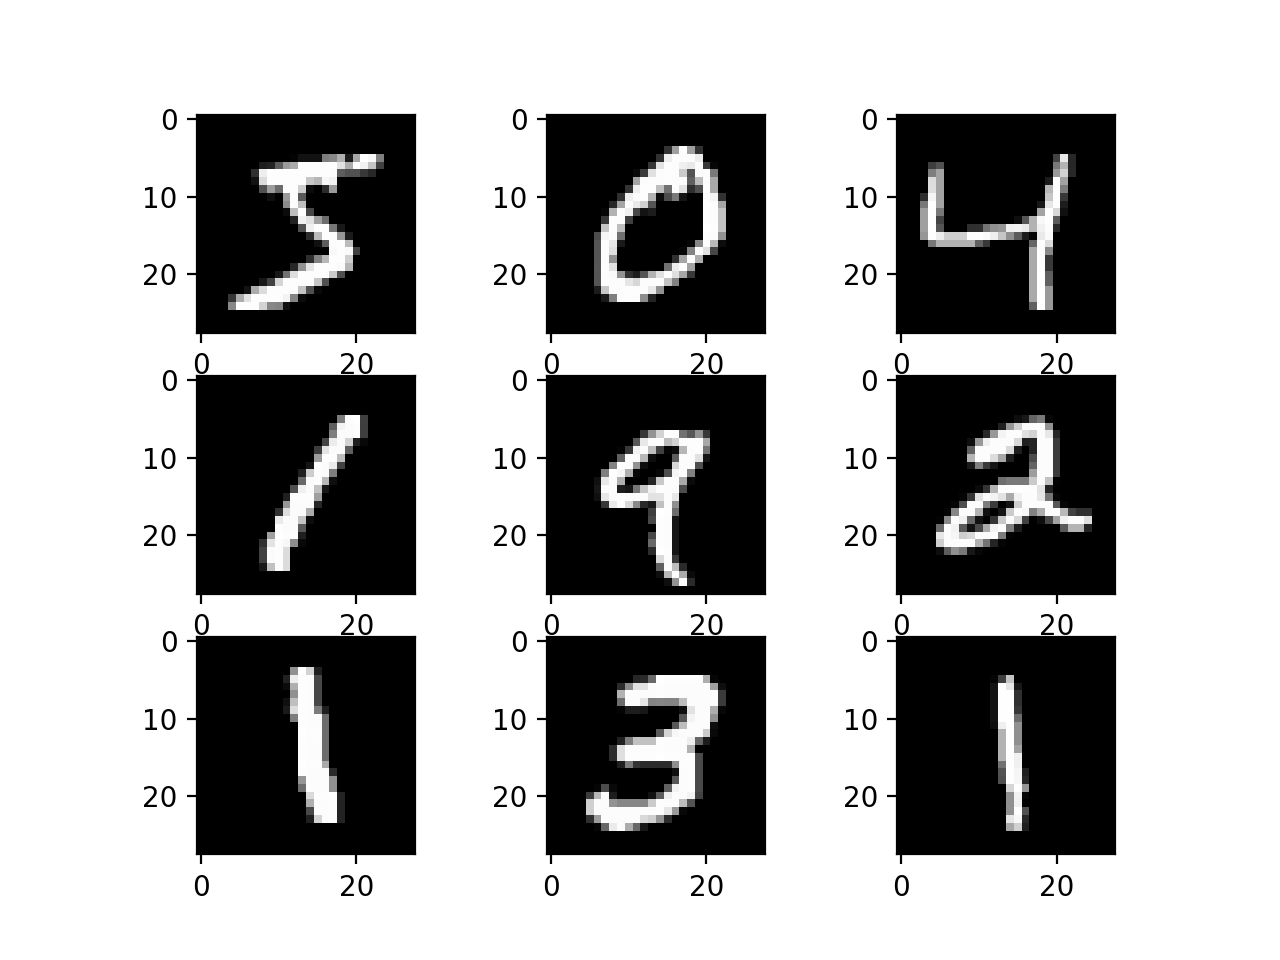

โดยการสร้าง AI ตัวนี้ขึ้นมา จะเรียงลำดับตาม Pipeline ของการ Train model ML
### 📌สามารถศึกษาก่อนได้ที่ [ลิงก์นี้](https://lucid.app/lucidchart/d3622941-01c3-4b32-886d-48c28cd3b353/edit?viewport_loc=-4941%2C-1000%2C15388%2C7120%2C0_0&invitationId=inv_b7865e54-762c-4788-b209-ccb00a0cdf73) 📌


#  **2 Import Library ที่เราต้องใช้**

In [ ]:
!pip install -q lightning wandb

  Preparing metadata (setup.py) ... done


In [ ]:
import lightning.pytorch as pl
from lightning.pytorch.loggers import WandbLogger

import torch
from torch.nn import CrossEntropyLoss
from torch import nn
from torch.utils.data import DataLoader, random_split,Dataset

from torchvision.transforms.functional import pil_to_tensor

from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, ToPILImage

from PIL import Image

import wandb

In [ ]:
from ipywidgets import widgets, VBox
from fastai.vision.all import PILImage

In [ ]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)

torch.backends.deterministic = True

# **3 Import MNIST Dataset**

เราจะใช้ Class **MNIST** ซึ่ง Import มาจาก torchvision ซึ่งเราสามารถใส่ parameters ได้หลายค่า และจะคืนค่าออกมาเป็น Object Dataset ที่เราต้องนำไปใช้ต่อไป น้อง ๆ สามารถเข้าไปที่ https://pytorch.org/vision/0.15/generated/torchvision.datasets.MNIST.html เพื่อดู parameters ที่ Class รับได้


---

**Acceptable Parameters**


1.   **root** (str) - path ที่เก็บ dataset นี้ไว้
2.   **train** (bool) - ถ้า True คืนค่ากลับมาเป็น Dataset สำหรับการ train
3.   **download** (bool) - Download หากไม่มี dataset นี้
4.   **transform** (optional[Callable]) - ฟังก์ชั่นของ torchvision.transform ที่อยากจำ apply ใส่รูปทั้งหมด เช่น torchvision.transforms.ToTensor(), torchvision.transforms.Resize() เป็นต้น



---

โดยปกติแล้ว เมื่อเราจะ train model เราต้องใช้ **tensor** ในการนำไป train ดังนั้นเราต้องเปลี่ยนรูปพวกนั้นเป็น torch.Tensor ซะก่อน เพื่อไม่ให้เสียเวลาในภายหลัง เราสามารถนำ ToTensor() ไปใส่ใน argument transform ได้เลยเพื่อรับ Tensor กลับมา แทนที่ PIL Image

In [ ]:
train_val_dataset = MNIST('mnist_dataset', train=True, download=True, transform=ToTensor())
test_dataset = MNIST('mnist_dataset', train=False, download=True, transform=ToTensor())

100%|██████████| 9912422/9912422 [00:00<00:00, 27750330.22it/s]


Extracting mnist_dataset/MNIST/raw/train-images-idx3-ubyte.gz to mnist_dataset/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 99946942.10it/s]

Extracting mnist_dataset/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_dataset/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 26408022.56it/s]


Extracting mnist_dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_dataset/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6211453.79it/s]


Extracting mnist_dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_dataset/MNIST/raw



In [ ]:
len(train_val_dataset), len(test_dataset)

(60000, 10000)

# **4 Data Preprocessing**

ในส่วนนี้ เราจะนำรูปมา Preprocess เพื่อให้เราสามารถ train ได้อย่างสงบสุข เพราะว่าบางที data ของเราอาจจะมีสิ่งที่เราไม่ต้องการให้มี เช่น



*   ขนาดรูปภาพที่ไม่เท่ากัน
*   มีรูปตัวอักษร ปะปนเข้ามาใน Dataset ตัวเลขของเรา
*   มีรูปที่มืด เบลอ จนทำให้ dataset ไม่สะอาด
*   ไม่มี Label


หรือบางครั้ง เราก็ต้องการแยกระหว่าง train, validation กับ test dataset ในอัตราส่วน 70%, 20%, และ 10%

การกระทำเหล่านี้ จัดอยู่ใน Preprocessing ทั้งสิ้น เพื่อให้เราสามารถ Train Model ได้อย่างราบรื่น





### 4.1 Data Splitting
ถ้าเราได้รูปมา 100 รูป เราจะไม่ใช้ทั้ง 100 รูปนั้นให้ Model เรียน แต่เราจะใช้แค่บางส่วนในการ Train เราแบ่งดังนี้


1.   **70%** จะใช้สำหรับการ Train เพื่อให้โมเดลได้เห็น และเรียน
2.   **20%** จะใช้สำหรับการทดสอบเมื่อจบการ Train หนึ่งครั้ง เรียกว่า Validation Dataset
3.   **10%** จะเป็นข้อมูลใช้ทดสอบเมื่อจบการ Train ทั้งหมด เรียกว่า Testing Dataset


เนื่องจากว่าเรามี train_val_dataset อยู่ 60,000 รูป และ test_dataset อยู่ 10,000 รูป ดังนั้นเราจะใช้ random_split ในการแยก train_val_dataset จาก 60,000 รูป ให้กลายเป็น train 80% (48,000 รูป) และ validation 20% (12,000 รูป)

ตัวเลขนี้สามารถเปลี่ยนได้ แต่ควรมี data ไว้สำหรับการ Train ให้เพียงพอ


In [ ]:
train_dataset, val_dataset = random_split(dataset=train_val_dataset, lengths=[0.8, 0.2])
print(f'Train Dataset Size: {len(train_dataset)}\nValidation Dataset Size:  {len(val_dataset)}\n Test Dataset Size: {len(test_dataset)}')

Train Dataset Size: 48000
Validation Dataset Size:  12000
 Test Dataset Size: 10000


## 4.2 Visualize แสดงข้อมูล 1 ตัว

เมื่อเราได้ Dataset Class ไม่ว่าจะเป็น train_dataset, val_dataset ก็ตาม แต่ว่า dataset เหล่านี้จำเป็นจะต้องมีตัวที่ไป*หยิบ* ไป*ดึง*ข้อมูลมา ตาม settings ที่เราต้องการ เราเรียกสิ่งนี้ว่า DataLoader ซึ่งเป็น Class ที่รับค่าดังนี้


---

**Acceptable Parameters**


1.   **dataset** (Dataset) - Dataset Object
2.   **batch_size** (int, optional) - ขนาดของ sample ต่อการโหลดข้อมูลหนึ่งครั้ง (default: 1)
3.   **shuffle** (bool, optional) - ถ้า True จะเรียงสับเปลี่ยน data ใน Dataset ใหม่ทั้งหมดต่อหนึ่ง Epoch


DataLoader มี acceptable parameters อีกมาก สามารถเข้าไปดูได้ที่ https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader

---

ในกรณีนี้ เรา**แค่** ต้องการตรวจสอบ (Inspect) ข้อมูลของเราแค่ตัวเดียวจาก 48,000 ข้อมูลใน train_dataset


In [ ]:
# Create Inspector DataLoader
batch_size = 1
inspector_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# Iterate over dataloader once
img, label = next(iter(inspector_loader))

print(label)

print('Image type: ', type(img))


if batch_size == 1:
    # squeeze image from 4-Dimensional tensor to 3-Dimensional tensor
    print(img.shape)
    img = img.squeeze(0)
    print(img.shape)
    display(ToPILImage()(img))

if 1 < batch_size < 12:
    for i in range(batch_size):
        display(ToPILImage()(img[i]))
        print('\n')

tensor([8])
Image type:  <class 'torch.Tensor'>
torch.Size([1, 1, 28, 28])
torch.Size([1, 28, 28])


## **4.3 Define DataLoader ที่จะใช้จริง**

เมื่อเรามั่นใจแล้วว่า Dataset ของเราถูกต้อง และคืนค่ากลับมา 2 ค่าคือ


1.   **img** (torch.Tensor) - เป็น tensor ที่มีขนาดคือ [batch_size, 1, 28, 28] กล่าวคือเป็น matrix 4 มิติ คือจำนวนรูป, จำนวนแชนแนลของรูป, ความสูง และความกว้าง ตามลำดับ
2.   **target** (torch.Tensor) - เป็น tensor ขนาด [batch_size] เก็บ Label ของแต่ละรูปตามลำดับไว้

ถ้าน้อง ๆ ยังไม่เห็นภาพ ที่เซลล์ด้านบน ลองปรับ batch_size ของ inspector_loader เป็น 8 จะเห็นภาพมากขึ้น



In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

# **5 สร้าง Model**

Model ในทาง Machine Learning มีหลากหลายรูปแบบมาก แต่ที่เป็นที่เข้าใจได้ง่ายและให้ผลลัพธ์ที่พอใช้ได้คือการใช้ Fully Connected Neural Network (NN) แต่ที่เป็นที่นิยมกว่าและได้ผลลัพธ์ที่ดีกว่าคือการใช้ Convolutional Neural Network (CNN) ถือว่าเป็น Deep Learning ประเภทหนึ่ง น้อง ๆ สามารถศึกษา NN และ CNN อย่างง่าย ๆ ได้ที่นี่ [Neural Network คืออะไร?](https://medium.com/mmp-li/deep-learning-%E0%B9%81%E0%B8%9A%E0%B8%9A%E0%B8%89%E0%B8%9A%E0%B8%B1%E0%B8%9A%E0%B8%84%E0%B8%99%E0%B8%AA%E0%B8%B2%E0%B8%A1%E0%B8%B1%E0%B8%8D%E0%B8%8A%E0%B8%99-ep-1-neural-network-history-f7789236a9a3) |   [CNN คืออะไร?](https://medium.com/@natthawatphongchit/%E0%B8%A1%E0%B8%B2%E0%B8%A5%E0%B8%AD%E0%B8%87%E0%B8%94%E0%B8%B9%E0%B8%A7%E0%B8%B4%E0%B8%98%E0%B8%B5%E0%B8%81%E0%B8%B2%E0%B8%A3%E0%B8%84%E0%B8%B4%E0%B8%94%E0%B8%82%E0%B8%AD%E0%B8%87-cnn-%E0%B8%81%E0%B8%B1%E0%B8%99-e3f5d73eebaa) | [Tensorflow Neural Network](https://playground.tensorflow.org/)

โมเดลที่เราจะมาสร้างในวันนี้คือ NN แบบที่เรียบง่ายและเข้าใจง่าย ประกอบไปด้วยส่วนประกอบดังภาพ

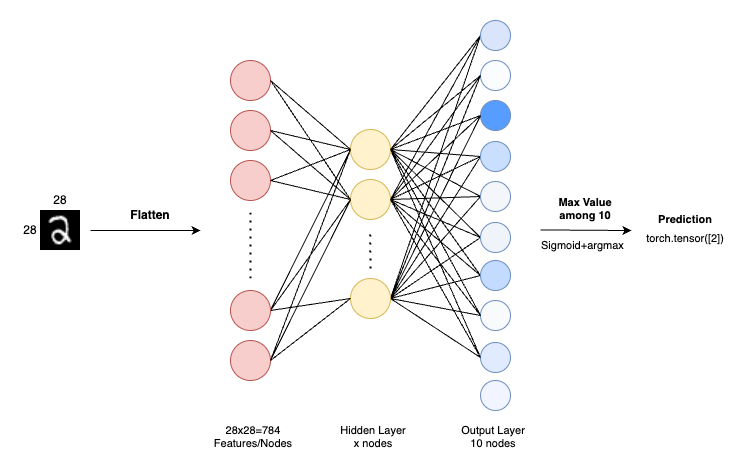

ซึ่งเราจำเป็นจะต้องสร้างโมเดลด้วยการ Inherit Class nn.Module ตามโค้ดด้านล้าง ซึ่งควรประกอบไปด้วยสองส่วนได้แต่
1. **\_\_init\_\_()** - ซึ่งจะเป็นตัวกำหนดลำดับของโมเดลของเราว่า เมื่อมีข้อมูล (tensor) ใส่เข้าไป จะทำอย่างไรต่อ

2. **forward()** - เป็นฟังก์ชั่นสำหรับการนำข้อมูล (tensor) เข้าไป feed ใส่ในโมเดล และได้ผลลัพธ์ออกมา



In [ ]:
class MyMNISTModel(nn.Module):
    def __init__(self, n_in, hidden_layer_nodes):
        super(MyMNISTModel, self).__init__()
        self.model = nn.Sequential(nn.Flatten(),
                                   nn.Linear(n_in, hidden_layer_nodes),
                                   nn.ReLU(),
                                   nn.Linear(hidden_layer_nodes, 10))

    def forward(self, x):
        return self.model(x)

In [ ]:
x, y = next(iter(train_dataloader))
model = MyMNISTModel(28*28, 64)
print(f'The shape of raw image tensors: {x.shape} \n and when raw image is fed through the model:  {model(x).shape}')

The shape of raw image tensors: torch.Size([256, 1, 28, 28]) 
 and when raw image is fed through the model:  torch.Size([256, 10])


จากด้านบน เราจะเห็นว่า tensor ณ dimension ที่ 0 (dim=0) มีค่า 256 นั่นคือมีรูปทั้งหมด 256 รูป แต่ละรูปมี 1 channel (dim=1) ที่มีความสูง 28 (dim=2) กว้าง 28 (dim=3)

แต่เมื่อเรานำ tensor 4D นี้เข้าไปยังโมเดล จะให้ผลลัพธ์ออกมามีแค่ 2D ได้แก่ 256 รูป (dim=0) และแต่ละรูปมี 10 ค่า (dim=1) ซึ่งเป็นความน่าจะเป็นของแต่ละ Class ตั้งแต่เลขโดด 0 ถึง 9 นั่นเอง ยิ่งค่าไหนใน 10 ค่านี้ของผลลัพธ์มากขึ้นเท่าไหร่ ยิ่งมีความน่าจะเป็นที่จะเป็นเลขนั้นมากขึ้นสำหรับโมเดลเรา

## **6 สร้าง Lightning Module สำหรับการ Train**

เมื่อเราได้โมเดลแล้ว มันไม่สามารถ Train ด้วยตัวมันเองได้ มันต้องมีกลไกที่บอกว่าจะเอารูปมาจากไหน, feed รูปเข้าตอนไหน, ให้ loss ออกมาแล้วไปทำอะไรต่อ, Optimizer ของเราคืออะไร ฯลฯ ดังนั้นเราจะใช้ pl.LightningModule เป็น Class ในการเขียน script ไว้สำหรับการ train


---

ส่วนประกอบของ pl.LightningModule ที่จำเป็นมีอยู่ด้วยกัน 4 ส่วนหลัก ๆ ได้แก่
1. `__init__(self, *args, **kwargs)` -
สำหรับส่วนนี้เป็นตัวที่ Initialize ที่เป็นฟังก์ชั่นกำหนดเริ่มต้น ข้อมูลที่จำเป็นที่จะนำไปใช้สำหรับทั้ง class ควรกำหนดและประกาศไว้ที่นี่เช่น `model`, `loss_function`, `learning_rate`
2. `forward(self, x)` - ฟังก์ชั่นที่หน้าที่คล้าย ๆ กับ `forward` ของโมเดล nn.Module ไว้ใช้สำหรับนำ raw data $→ x$ (tensor ของรูป) ใส่เข้าไปในโมเดล แล้ว return กลับมาเป็นผลลัพธ์
3. `configure_optimizers(self)` - เป็นตัวกำหนด optimizer ของการเทรนของเรา ว่าใครจะเป็นคนปรับ parameters (weight&bias) ของ model ในที่นี้ **Adam optimizer** เป็นที่นิยมมากที่สุด ให้ return optimizer จากฟังก์ชั่นนี้ โดย optimizers ต่าง ๆ สามารถดูได้จาก https://pytorch.org/docs/stable/optim.html
4. `training_step(self, batch, batch_idx)` - ฟังก์ชั่นนี้จะถูกรันทุก ๆ การ train model หนึ่ง step โดย batch ที่ใส่มานี้ จะประกอบไปด้วยค่าที่คืนมาอันเดียวกับ dataloader ของเรา ซึ่งในที่นี้จะคืนกลับมาสองค่าคือ 4D tensor ของรูปที่มีขนาดตาม batch_size $x$ และ Label หรือค่าจริงของแต่ละรูป $y$ ในฟังก์ชั่นนี้เราจะทำทั้งการ forward $x$ เข้าไปยังโมเดล, คำนวณ loss, logging (การบันทึกค่า), และคืน loss กลับไปให้โมเดลปรับ parameters


---
อย่างไรก็ดี pl.Lightning Module สามารถเพิ่มฟังก์ชั่นอื่น ๆ (ซึ่งบางอันพี่สนับสนุนให้ทำ) สำหรับการ train AI ที่สมบูรณ์ เช่น
1. `validation_step(self, batch, batch_idx)` - จะถูกเรียกใช้ทุกครั้งเมื่อ train เสร็จ 1 Epoch ซึ่งจะใช้ dataset เป็น validation dataset

2. `test_step(self, batch, batch_idx)` - จะถูกเรียกใช้เมื่อเรียก `trainer.test()` เท่านั้น

3. `training_epoch_end(self, batch, batch_idx)` - จะถูกเรียกใช้เมื่อ train เสร็จ 1 Epoch และเรียกใช้ก่อน `validation_step`


In [ ]:
class DigitClassifier(pl.LightningModule):
    def __init__(self, architecture, lr, *args, **kwargs):
        super().__init__(*args, **kwargs)

        # Declare Model
        self.model = architecture

        # Learning Rate
        self.lr = lr

        # Define Loss function
        self.loss_fn = CrossEntropyLoss()

        # Save hyperparams for reproducibility
        self.save_hyperparameters()

    def forward(self, x):
        # feed x to model
        prediction = self.model(x)
        return prediction

    def configure_optimizers(self):
        # Use Adam as a optimizer
        return torch.optim.Adam(self.parameters(), lr=self.lr)

    def training_step(self, batch, batch_idx):
        # x is our 4D tensor of raw images, y is 1D tensor of labels
        x, y = batch
        y_hat = self.forward(x)
        loss = self.loss_fn(y_hat, y) # Calculate loss
        self.log('training_loss', loss) # Logging loss function
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.loss_fn(y_hat, y)
        accuracy = (y_hat.argmax(dim=1) == y).sum() / len(y) # calculate accuracy
        self.log('val_loss', loss)
        self.log('val_acc', accuracy)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.loss_fn(y_hat, y)
        accuracy = (y_hat.argmax(dim=1) == y).sum() / len(y)  # calculate accuracy
        self.log('test_loss', loss)
        self.log('test_acc', accuracy)
        return loss



## **7 Train Model**

ในส่วนนี้ การเทรนทั้งหมดจะถูกเทรนผ่าน Trainer ที่เราสามารถกำหนดพฤติกรรมชั้นบนของการเทรนได้ เช่น


* Train กี่ Epoch
* Lightning Model เราคืออะไร
* อยากให้บันทึกข้อมูล (Logging) ใส่ Logger อะไร
* อยากให้การเทรนหยุดเมื่อใด
* ใช้ GPU, CPU, หรือหน่วยใดในการประมวลผล
* ใช้ GPU กี่ตัวในการเทรน ตัวไหนบ้าง

และอีกมากมาย ซึ่งสามารถศึกษาได้จาก https://lightning.ai/docs/pytorch/stable/common/trainer.html

ในการเทรนที่นี้เราจะใช้ WandbLogger (https://wandb.ai/site) สำหรับการ Log ข้อมูล ซึ่งสามารถแชร์ให้ผู้อื่นได้ และข้อมูลจะถูกบันทึกไว้บน cloud ไม่ใช่คอมพิวเตอร์ส่วนตัว โดยสามารถประกาศได้ดังนี้
`wandb_logger = WandbLogger(name='...', project='...')` สามารถใส่ `name` เป็นชื่อของการ log แต่ละครั้ง และ `project` เป็นชื่อของโปรเจกต์ทั้งหมด หากอยู่ใน project MNIST นี้อยู่แล้ว ก็ไม่ควรเปลี่ยนชื่อ



---

เมื่อเราประกาศ trainer เรียบร้อย ส่วนต่อไปคือการเรียกใช้ trainer ให้ทำอะไรสักอย่าง:


*   `trainer.fit(model, train_dataloaders, valdataloaders)` - สำหรับการ train (fit) โมเดล
*   `trainer.test()` - สำหรับการ test model ของเรา โดยจะเรียกใช้แค่ method `test_step` ของ Lightning Module เท่านั้น


In [ ]:
# Declare neccessary info.

architecture = MyMNISTModel(28*28, 8)
lr = 0.0001
max_epochs = 50

In [ ]:
# create wandb_logger object instance for logging
wandb_logger = WandbLogger(name='Trail_1', project='MNIST Classification')

# declare lightning module for training
model = DigitClassifier(architecture=architecture, lr=lr)

wandb: Currently logged in as: vetitk. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'architecture' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['architecture'])`.
  rank_zero_warn(


In [ ]:
# create trainer
trainer = pl.Trainer(max_epochs=max_epochs, logger=wandb_logger)

# train model with train_dataloader, val_dataloader
trainer.fit(model=model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name    | Type             | Params
---------------------------------------------
0 | model   | MyMNISTModel     | 6.4 K 
1 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
6.4 K     Trainable params
0         Non-trainable params
6.4 K     Total params
0.025     Total estimated model params size (MB)
INFO:lightning.pytor

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=50` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


In [ ]:
trainer.test(dataloaders=test_dataloader)
wandb.finish()

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
INFO: Restoring states from the checkpoint path at ./MNIST Classification/ezhwhmla/checkpoints/epoch=49-step=9350.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at ./MNIST Classification/ezhwhmla/checkpoints/epoch=49-step=9350.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at ./MNIST Classification/ezhwhmla/checkpoints/epoch=49-step=9350.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights fr

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9043999910354614     │
│         test_loss         │    0.32648375630378723    │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
test_acc,▁
test_loss,▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
training_loss,█▇▆▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▂▁▂▁▁▂▁▁▂▂▂▁▁▁▁▂▁▁
val_acc,▁▃▄▅▆▆▇▇▇▇▇▇▇▇██████████████████████████
val_loss,█▇▆▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,50
test_acc,0.9044
test_loss,0.32648
trainer/global_step,9350


# **8 ประเมินประสิทธิภาพ และลองใช้งาน (Evaluation and Inference)**

เมื่อเราฝึกโมเดลเสร็จ เราจะได้ไฟล์สำหรับเก็บ Weight&Bias มา ซึ่งตอนนี้ยังเป็นแค่ชั่วคราว (Checkpoint) ในรูปแบบนามสกุลไฟล์ .ckpt ซึ่งมักจะถูกบันทึกไว้ที่ **[ชื่อ project]/[runs]** ให้หาการ train ที่ต้องการแล้ว copy path ของไฟล์นั้นออกมา (เมื่อเรียกใช้ `wandb.finish()` จะมี run id เป็นตัวอักษร 8 ตัว ในที่นี้คือ ezhwhmla) โค้ดด้านล่างนี้เป็นตัวอย่างของ path ของ .ckpt ที่ train แล้ว


---

เมื่อได้ path ของ checkpoint มาแล้ว เราจะนำ pl.LightningModule ของเราโหลด checkpoint นี้เพื่อนำ weight&bias ไปใส่ เมื่อทำแล้ว เราจะได้ model ที่มีความสามารถเหมือนกับตอนที่ train ถึง checkpoint ดังกล่าวทันที เพราะทำให้ model เราถูกใส่ parameters ที่เก็บไว้ในไฟล์ .ckpt เมื่อตอน train นั่นเอง

ถ้าจะให้พี่เปรียบเทียบก็คงเหมือนสมองที่ถอดได้ ตอนเด็ก ๆ เรายังไม่รู้อะไรเหมือนกับ model ตอนที่ยังไม่ถูก train และ parameters ยังให้ผลลัพธ์มั่ว ๆ แต่ถ้าเรานำสมองเด็กโต (ถูก train มาแล้ว) มาใส่ (load_from_checkpoint) ก็จะทำให้เด็กนั้นมีความสามารถเหมือนกับเด็กโตนั่นเอง

In [ ]:
checkpoint_path = "/content/MNIST Classification/ezhwhmla/checkpoints/epoch=49-step=9350.ckpt"

# load weights from checkpoint
model = DigitClassifier.load_from_checkpoint(checkpoint_path, architecture=architecture, lr=lr)

# Convert Evaluation Mode (instead of Training Mode)
model.eval()

DigitClassifier(
  (architecture): Sequential(
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=10, bias=True)
  )
)

คราวนี้ลองนำ model ที่ได้มา มาทดสอบโดยการใส่รูปหนึ่งรูปเข้าไปยังโมเดลที่ train มาแล้วและดูผลลัพธ์

In [ ]:
x, y = next(iter(train_dataloader))
x, y = x[0], y[0]
display(ToPILImage()(x))
print('Label:', y)
output = model(x)
print('Model Output: ', output)

prediction = output.argmax()
print('Model Prediction: ', prediction)

Label: tensor(1)
Model Output:  tensor([[-9.8202,  5.5095,  0.3835, -0.8979, -5.0598, -4.6585, -0.8571, -1.0334,
         -0.9898, -3.3559]], grad_fn=<AddmmBackward0>)
Model Prediction:  tensor(1)


สวยยยยยยยยยยย

# **9 นำโมเดลไปใช้ (Model Deployment)**

จริง ๆ แล้วเราสามารถนำโมเดลไปใช้ได้หลากหลายวิธี เช่น


1.   Export เป็น .pt - เนื่องจาก .ckpt เป็นแค่ checkpoint ของ Pytorch Lightning แต่หากเราต้องการนำไปใช้งานใน Production ก็อาจจะจำเป็นต้อง export model เป็นนามสกุล .pt (Pytorch File) สำหรับ PyTorch runtime
2.   Export เป็น .onnx - เป็น format ที่ได้รับความนิยมมาก เพราะเร็ว นิยมใช้ และสามารถนำไปรันบนหลากหลาย platform หลากหลายภาษา เช่น C++, Java, Python หรือนำไปรันใน Low level Hardware ตามโรงงานอุตสาหกรรมได้ด้วย

ในบทเรียนนี้เราจะยังไม่ Export แต่จะสร้าง Widget ง่าย ๆ ที่เราสามารถอัพโหลดรูปภาพแล้วจะแสดงผลลัพธ์ออกมาได้



In [ ]:
# Build widget
btn_upload = widgets.FileUpload()
out_pl = widgets.Output()
lbl_pred = widgets.Label()
btn_run = widgets.Button(description='Classify')

In [ ]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    img_tensor = pil_to_tensor(img.convert('L').resize((28, 28)))/255.0
    pred = model(img_tensor).argmax(dim=1)
    lbl_pred.value = f'Prediction: {pred}'

btn_run.on_click(on_click_classify)

In [ ]:
VBox([widgets.Label('Select the handwritten to classify'),
      btn_upload, btn_run, out_pl, lbl_pred])